#TF-IDF + Naïve Bayes and SGD
##Preprocessing
Import statements

In [1]:
import pandas as pd
import re
from nltk import WordNetLemmatizer, word_tokenize, download
from nltk.corpus import stopwords
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import seaborn as sns

download the majority of languages in the dataset as a set, then create a union of them for further sanitation.

In [2]:
download('stopwords')
# Create individual sets for each language's stopwords
english_stopwords = set(stopwords.words('english'))
spanish_stopwords = set(stopwords.words('spanish'))
french_stopwords = set(stopwords.words('french'))
italian_stopwords = set(stopwords.words('italian'))
portuguese_stopwords = set(stopwords.words('portuguese'))
finnish_stopwords = set(stopwords.words('finnish'))
swedish_stopwords = set(stopwords.words('swedish'))
catalan_stopwords = set(stopwords.words('catalan'))
hungarian_stopwords = set(stopwords.words('hungarian'))

# Use the union method to combine all the sets
stop_words = english_stopwords.union(spanish_stopwords, french_stopwords, italian_stopwords, portuguese_stopwords, finnish_stopwords, swedish_stopwords, catalan_stopwords, hungarian_stopwords)

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


define the file paths

In [3]:
# File paths
train_file_path = "mediaeval-2015-trainingset.txt"
test_file_path = "mediaeval-2015-testset.txt"

1.define the pattern of emojis
2.preprocess_text:
replace all urls with a placeholder [U] by pattern matching
convert all texts to lower case
tokenize and lemmatize all the texts
remove all extra white spaces

In [4]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def preprocess_text(text):
    # Replace URLs with a placeholder
    text = re.sub(r'http\S+|www\S+|https\S+', '[U]', text, flags=re.MULTILINE)
    # Replace emojis with ~
    text = emoji_pattern.sub('~', text)
    # Replace non ascii with
    #text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = text.lower()
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(lemmatized_words)
    # Remove extra whitespaces
    text = text.strip()
    return text

generate_image_id_mapping:
for all imageId(s), in the form of <event>_<label(real/fake)>_<number>, convert them to a dictionary where they are encoded to numbers as the original id could introduce noice to the data.
load_and_process_data:
read all data
for tweetText, after sanitation if they are empty, fill them with ''
replace all humor labels with fake
load all the data and concat them to a string, seperating each attribute with <
return training data as X_train, label as y_train
return testing data as X_test, label as y_test

In [5]:
def generate_image_id_mapping(data):
    unique_image_ids = data['imageId(s)'].unique()
    image_id_dict = {id: f"{i}" for i, id in enumerate(unique_image_ids, start=1)}
    return image_id_dict

def load_and_preprocess_data():
    # Load training dataset
    train_data = pd.read_csv(train_file_path, sep='\t')
    # Handle NaN values for tweetText
    train_data['tweetText'] = train_data['tweetText'].fillna('')

    # Load testing dataset
    test_data = pd.read_csv(test_file_path, sep='\t')
    test_data['tweetText'] = test_data['tweetText'].fillna('')

    # Generate image ID mapping from combined dataset
    combined_data = pd.concat([train_data, test_data])
    image_id_dict = generate_image_id_mapping(combined_data)

    # Replace image IDs with generated IDs in training data
    train_data['imageId(s)'] = train_data['imageId(s)'].map(image_id_dict)
    # Preprocess text and replace labels in training dataset
    train_data['tweetText'] = train_data['tweetText'].apply(preprocess_text)
    train_data['label'] = train_data['label'].replace('humor', 'fake')
    # Select relevant columns for features
    X_train = train_data['tweetText'].astype(str) + '<' + \
              train_data['userId'].astype(str) + '<' + \
              train_data['timestamp'].astype(str) + '<' + \
              train_data['imageId(s)'].astype(str)
    y_train = train_data['label']

    # Replace image IDs with generated IDs in testing data
    test_data['imageId(s)'] = test_data['imageId(s)'].map(image_id_dict)
    # Preprocess text and replace labels in testing dataset
    test_data['tweetText'] = test_data['tweetText'].apply(preprocess_text)
    test_data['label'] = test_data['label'].replace('humor', 'fake')
    # Select relevant columns for features
    X_test = test_data['tweetText'].astype(str) + '<' + \
             test_data['userId'].astype(str) + '<' + \
             test_data['timestamp'].astype(str) + '<' + \
             test_data['imageId(s)'].astype(str)
    y_test = test_data['label']

    return X_train, y_train, X_test, y_test

By calling load_and_preprocess_data(), load the training and testing set
Initialize the pipeline using TF-IDF as feature extractor and multinomial Naive Bayes as classifier.
Computes class weights to handle class imbalance in the data.
A grid search is performed to optimize the hyperparameters of the TF-IDF vectorizer and the Naive Bayes classifier, using a 10-fold cross-validation and aiming to maximize the weighted F1 score.
After training, the best model is updated to incorporate the previously computed class weights into the Naive Bayes classifier, which helps to adjust the model for imbalanced classes.

In [6]:
X_train, y_train, X_test, y_test = load_and_preprocess_data()
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Design and implement the pipeline with TF-IDF and Naive Bayes
pipeline_tfidf_bayes = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('naive_bayes', MultinomialNB())
])

# Set up the grid search
parameters = {
    'tfidf_vectorizer__max_features': [3700],
    'naive_bayes__alpha': [0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1, 1.5, 2],
}
grid_search = GridSearchCV(pipeline_tfidf_bayes, parameters, cv=10, n_jobs=-1, scoring='f1_weighted')
# Train the model with grid search
grid_search.fit(X_train, y_train)
# Best model
best_model = grid_search.best_estimator_
# Update the Naive Bayes classifier in the pipeline with class weights
best_model.set_params(naive_bayes__class_prior=class_weight_dict)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer(max_features=3700)),
                ('naive_bayes',
                 MultinomialNB(alpha=0.1,
                               class_prior={0: 0.7629863189397178,
                                            1: 1.450619792725056}))])

Starts by predicting the test set labels using the best model obtained from the grid search. The test labels are then binarized. The model's probability predictions for the class 'real' are calculated.

Next, precision and recall are computed for various thresholds, and the optimal threshold is determined by finding the maximum sum of precision and recall. This optimal threshold is then used to adjust the final predictions.

The model's accuracy and classification report are generated for both the optimized predictions on the test set and the original predictions on the training set.

In [7]:
# Make predictions on the test set
y_pred_tfidf_bayes = best_model.predict(X_test)
# Binarize the output labels for real and fake
y_test_binarized = label_binarize(y_test, classes=['fake', 'real'])
# Get the probability predictions
y_scores = best_model.predict_proba(X_test)[:, 1]  # probability of being 'real'
# Calculate precision and recall for various thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test_binarized, y_scores)
# Find the threshold that provides the best balance between precision and recall
optimal_idx = np.argmax(precisions + recalls)
optimal_threshold = thresholds[optimal_idx]
# Apply the optimal threshold to make final predictions
y_pred_optimized = (y_scores >= optimal_threshold).astype(int)
# Evaluate the model with the optimized threshold
accuracy_tfidf_bayes = accuracy_score(y_test_binarized, y_pred_optimized)
classification_rep_tfidf_bayes = classification_report(y_test_binarized, y_pred_optimized, zero_division=1, target_names=['fake', 'real'], digits= 3)
# Evaluate the model on the training set
y_train_pred = best_model.predict(X_train)

Plot the result into confusion matrix and print out the result.

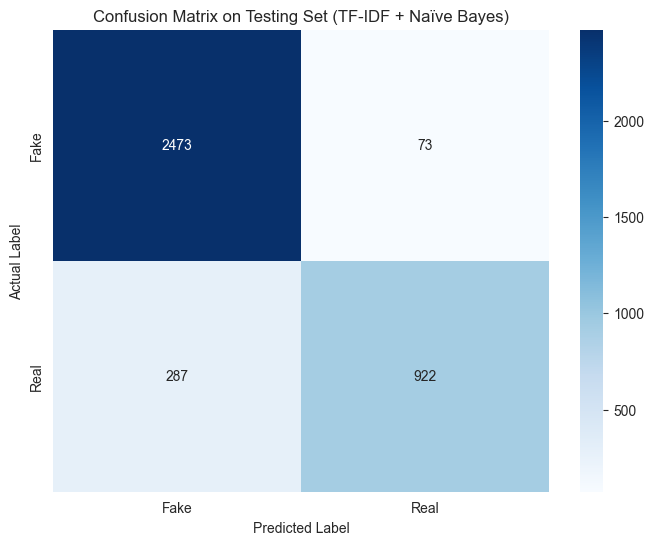

Performance on Testing Set (TF-IDF + Naïve Bayes)
Accuracy: 0.9041278295605859
Classification Report:
              precision    recall  f1-score   support

        fake      0.896     0.971     0.932      2546
        real      0.927     0.763     0.837      1209

    accuracy                          0.904      3755
   macro avg      0.911     0.867     0.884      3755
weighted avg      0.906     0.904     0.901      3755


In [8]:
# Confusion Matrix for the Training Set
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
# Confusion Matrix for the Testing Set (with Optimized Threshold)
confusion_matrix_test = confusion_matrix(y_test_binarized, y_pred_optimized)
def plot_confusion_matrix(conf_mat, title='Confusion Matrix', labels=['Fake', 'Real']):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)
    plt.show()
# Plot Confusion Matrix for Training Set
# plot_confusion_matrix(confusion_matrix_train, title='Confusion Matrix on Training Set')
# Plot Confusion Matrix for Testing Set (Optimized Threshold)
plot_confusion_matrix(confusion_matrix_test, title='Confusion Matrix on Testing Set (TF-IDF + Naïve Bayes)')
# Print the results
print('Performance on Testing Set (TF-IDF + Naïve Bayes)')
print(f'Accuracy: {accuracy_tfidf_bayes}')
print('Classification Report:')
print(classification_rep_tfidf_bayes)

In [9]:
X_train, y_train, X_test, y_test = load_and_preprocess_data()

# Define the pipeline
pipeline_tfidf_sgd = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(max_features=3500)),
    ('sgd', SGDClassifier())
])

# Parameters for Grid Search
param_grid = {
    #'sgd__loss': ['hinge', 'log', 'modified_huber'],
    'sgd__penalty': ['l2', 'l1', 'elasticnet'],
    'sgd__alpha': [0.0001, 0.001, 0.01, 0.2],
    #'sgd__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    #'sgd__eta0': [0.1, 0.01, 0.001]
}


# Create grid search object
grid_search = GridSearchCV(pipeline_tfidf_sgd, param_grid, cv=5, scoring='f1_weighted')

Using the trained model, predict on the test set and evaluate against the label, calculate the accuracy.

In [10]:
# Train the model using Grid Search
grid_search.fit(X_train, y_train)

# Best parameter set
print("Best parameters set found on development set:")
print(grid_search.best_params_)

# Evaluate the model with the best parameters
y_pred_tfidf_sgd = grid_search.predict(X_test)
accuracy_tfidf_sgd = accuracy_score(y_test, y_pred_tfidf_sgd)
classification_rep_tfidf_sgd = classification_report(y_test, y_pred_tfidf_sgd, zero_division=1, digits=3)

Best parameters set found on development set:
{'sgd__alpha': 0.0001, 'sgd__penalty': 'elasticnet'}


Plot the result into confusion matrix and print out the result.

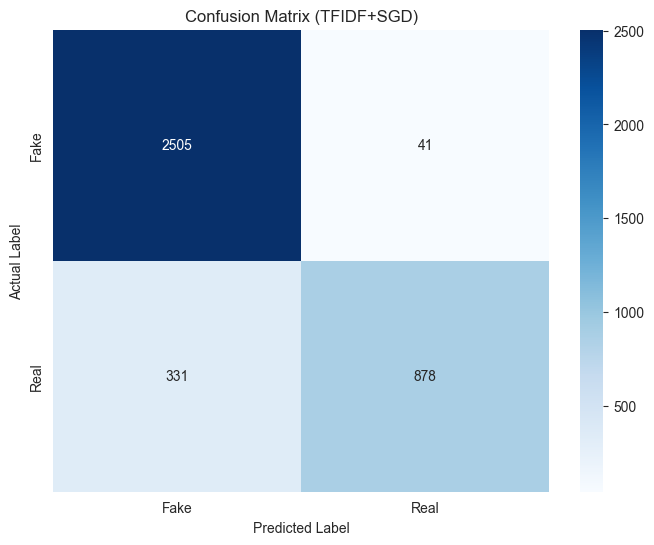

Performance on Testing Set(TFIDF+SGD):
Accuracy: 0.9009320905459387
Classification Report:
              precision    recall  f1-score   support

        fake      0.883     0.984     0.931      2546
        real      0.955     0.726     0.825      1209

    accuracy                          0.901      3755
   macro avg      0.919     0.855     0.878      3755
weighted avg      0.907     0.901     0.897      3755


In [11]:
# Confusion Matrix for the Testing Set
confusion_matrix_test = confusion_matrix(y_test, y_pred_tfidf_sgd)

# Plot Confusion Matrix for Testing Set
plot_confusion_matrix(confusion_matrix_test, title='Confusion Matrix (TFIDF+SGD)')

# Print the results for the testing set
print('Performance on Testing Set(TFIDF+SGD):')
print(f'Accuracy: {accuracy_tfidf_sgd}')
print('Classification Report:')
print(classification_rep_tfidf_sgd)